lambda max of A: 11.375529656810523
Filter coefs: [0.29399155 0.38311672 0.32289173]


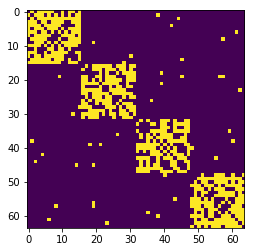

In [4]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64
Gs['k'] = 4
Gs['type_z'] = ds.CONT
Gs['p'] = 0.7
Gs['q'] = 0.015

# Signal parameters
K = 3
n_signals = 100
params = 4
n_p = 0.1

# Model parameters
fts = 150
epochs = 1000
lr = 0.001

JJ_samples = 1000

# Create graph
G = ds.create_graph(Gs, SEED)
A = G.W.todense()
Lambda_A, _ = utils.ordered_eig(A)
print('lambda max of A:', Lambda_A[0])
plt.figure()
plt.imshow(A)

# Create filter H and decoder
hs = np.random.rand(K)
hs /= np.sum(hs)
print('Filter coefs:', hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
H = x_dw.H
dec = GraphDecoder(fts, H)
JJ = dec.analytical_squared_jacobian()
Lambda, V = utils.ordered_eig(JJ)

start_time = time.time()

In [6]:
# Fit models
err = np.zeros((n_signals, epochs, G.N))
err_wrt_n = np.zeros((n_signals, epochs, G.N))
noisy_sigs = np.zeros((n_signals, G.N))
start_time = time.time()
for i in range(n_signals):
    x = ds.bandlimited_signal(Lambda, V, params)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    noisy_sigs[i, :] = x_n
    model = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    err_wrt_n[i, :, :], err[i, :, :], _ = model.fit(x_n, x, reduce_err=False)
    print('Signal', i, 'done')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

Signal 0 done
Signal 1 done
Signal 2 done
Signal 3 done
Signal 4 done
Signal 5 done
Signal 6 done
Signal 7 done
Signal 8 done
Signal 9 done
Signal 10 done
Signal 11 done
Signal 12 done
Signal 13 done
Signal 14 done
Signal 15 done
Signal 16 done
Signal 17 done
Signal 18 done
Signal 19 done
Signal 20 done
Signal 21 done
Signal 22 done
Signal 23 done
Signal 24 done
Signal 25 done
Signal 26 done
Signal 27 done
Signal 28 done
Signal 29 done
Signal 30 done
Signal 31 done
Signal 32 done
Signal 33 done
Signal 34 done
Signal 35 done
Signal 36 done
Signal 37 done
Signal 38 done
Signal 39 done
Signal 40 done
Signal 41 done
Signal 42 done
Signal 43 done
Signal 44 done
Signal 45 done
Signal 46 done
Signal 47 done
Signal 48 done
Signal 49 done
Signal 50 done
Signal 51 done
Signal 52 done
Signal 53 done
Signal 54 done
Signal 55 done
Signal 56 done
Signal 57 done
Signal 58 done
Signal 59 done
Signal 60 done
Signal 61 done
Signal 62 done
Signal 63 done
Signal 64 done
Signal 65 done
Signal 66 done
Signa

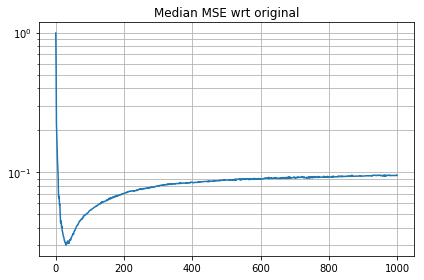

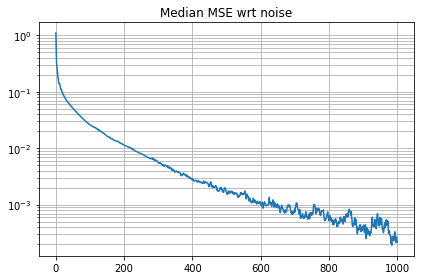

In [10]:
# Plots Median Error
med_mse = np.median(np.sum(err, axis=2), axis=0)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.title('Median MSE wrt original')
plt.tight_layout()

med_mse_n = np.median(np.sum(err_wrt_n, axis=2), axis=0)
plt.figure()
plt.semilogy(med_mse_n.T)
plt.grid(True, which='both')
plt.title('Median MSE wrt noise')
plt.tight_layout()

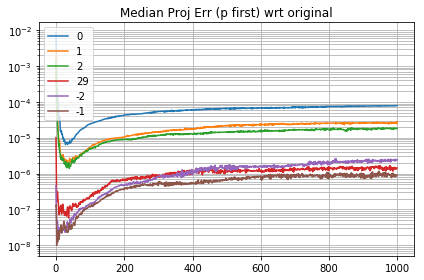

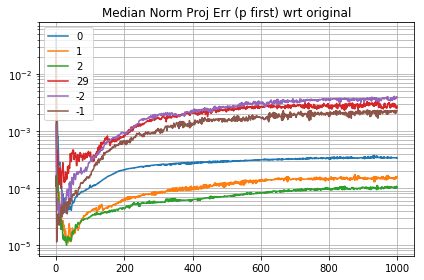

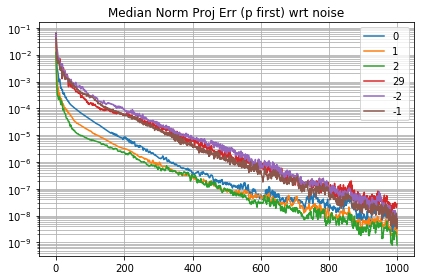

In [21]:
# Plot Errors on JJ eig
ind = np.array([0, 1, 2, 29, -2, -1])

## Using first p components
V_ind = V[:, ind]
proj_err = np.median(err.dot(V_ind)**2, axis=0)
plt.figure()
plt.semilogy(proj_err)
plt.legend(ind)
plt.grid(True, which='both')
plt.title('Median Proj Err (p first) wrt original')
plt.tight_layout()

## Normalizing
sigs_k_norms = noisy_sigs.dot(V_ind)**2
proj_err_norm = err.dot(V_ind)**2
proj_err_n_norm = err_wrt_n.dot(V_ind)**2
for i in range(n_signals):
    proj_err_norm[i, :, :] = proj_err_norm[i, :, :]/sigs_k_norms[i, :]
    proj_err_n_norm[i, :, :] = proj_err_n_norm[i, :, :]/sigs_k_norms[i, :]

proj_err_norm = np.median(proj_err_norm, axis=0)
proj_err_n_norm = np.median(proj_err_n_norm, axis=0)

plt.figure()
plt.semilogy(proj_err_norm)
plt.legend(ind)
plt.grid(True, which='both')
plt.title('Median Norm Proj Err (p first) wrt original')
plt.tight_layout()

plt.figure()
plt.semilogy(proj_err_n_norm)
plt.legend(ind)
plt.grid(True, which='both')
plt.title('Median Norm Proj Err (p first) wrt noise')
plt.tight_layout()


In [ ]:
plt.show()